#  Vortex beam metasurface


Vortex beam generation with metasurfaces leverages ultra-thin, planar structures to induce helical phase fronts in light, forming beams with orbital angular momentum (OAM). These metasurfaces are composed of precisely designed arrays of nanostructures that manipulate light at subwavelength scales, enabling the creation of vortex beams with high efficiency and accuracy. By engineering the phase profile of the metasurface, vortex beams with specific topological charges can be generated, providing compact and versatile solutions for applications in optical communication, quantum information processing, and particle manipulation.


In this notebook, we will use Tidy3D to simulate the plasmonic interface fabricated as described in the paper titled: `Yu, N., Genevet, P., Kats, M. A., Aieta, F., Tetienne, J.-P., Capasso, F., & Gaburro, Z. (n.d.). Light Propagation with Phase Discontinuities: Generalized Laws of Reflection and Refraction` [Doi: 10.1126/science.1210713](https://projects.iq.harvard.edu/files/capasso/files/2011_yu_et_al._science.pdf).

The metasurface is composed of 8 different unit cells, each distributed in one of the 8 octants of the metasurface. This arrangement creates a phase discontinuity in steps of $\pi/4$, inducing a spiral-like phase shift in an incident plane wave and generating a vortex beam.

<img src="img/vortexMetasurface_1.png" width="400" alt="Schematic of the experiment">


For more examples involving metamaterials and metasurfaces, please refer to our [example library](https://www.flexcompute.com/tidy3d/learning-center/example-library/), were you can find interesting case studies such as [Gradient metasurface reflector](https://www.flexcompute.com/tidy3d/examples/notebooks/GradientMetasurfaceReflector/), [Dielectric metasurface absorber](https://www.flexcompute.com/tidy3d/examples/notebooks/DielectricMetasurfaceAbsorber/), [Tunable chiral metasurface based on phase change material](https://www.flexcompute.com/tidy3d/examples/notebooks/TunableChiralMetasurface/) and a [inverse-design-optimized diffractive metasurface](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin13Metasurface/).
 

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it. 

## Simulation Setup

First, we will import the necessary libraries.

In [1]:
# importing libraries

import tidy3d as td
import numpy as np
from tidy3d import web
import matplotlib.pyplot as plt
from warnings import warn

The simulation will be parameterized by the number of unit cells in each direction (variable `N`), the distance of the source from the structure and from the PML, and the lattice constant.

The model consists of a semi-infinite silicon substrate in the -z direction, the metasurface, and an air region. An x-polarized plane wave is incident from the -z to the +z direction. A field monitor is placed to store the field profile in the frequency domain and project it to the far-field.

### Simulation Parameters

It is always good practice in FDTD simulations to parameterize the setup. This way, changing the structure only requires modifying a single variable.

In [2]:
N = 20

# even distribution is used to avoid octant ambiguities
if N % 2 != 0:
    N += 1
    warn("Odd numbers of unit cells are not allowed. Adding +1 to the NN variable.")

# target wavelength
Wl = 8

# lattice constant
lattice_constant = 1.5

# defining the central frequency and linewidth of the source
fcen = td.C_0 / Wl
fwidth = 0.2 * fcen

# simulation run time
run_time = 1e-12


# parameters of the fabricated antennas
width = 0.22
thickness = 0.05

# distance of the source from structures and pml
distance_source_structure = 2
distance_source_pml = 2

Now, we will define each parameter needed to build the simulation as a function of the parameters defined above:

In [3]:
# the size of the metasurface plane as a function of the number of unit cells and the lattice constant
#   a 1.5 lattice constant is added on each side to avoid structures touching the PML

sx = (N + 3) * lattice_constant + 12
sy = sx

# distance between monitor - source and monitor - PML
pad_monitor = 2

# defining the z-size of the simulation
sz = distance_source_structure + distance_source_pml + pad_monitor*2 + thickness

# defining the thickness of the substrate region
substrate_thickness = distance_source_structure + distance_source_pml

# defining the Z position of the metasurface
structure_z_position = -sz / 2 + substrate_thickness + thickness / 2

# defining monitor Z position
monitor_z_position = structure_z_position + pad_monitor

# defining the center position and size of the source
center_source = (0, 0, -sz / 2 + substrate_thickness / 2)
size_source = (td.inf, td.inf, 0)

Here, we will define an auxiliary function to return the antenna structure. The antenna is modeled as two [Box](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Box.html) arms that are tilted apart from each other by the angle `delta`. The antennas are then rotated by an angle `theta` around an axis that passes through their center, defined as the junction of the arms. To make the structures smoother and more similar to the SEM images, a [cylinder](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Cylinder.html) is added at the arms' junction.

The `vAntennaBlock` function returns a [Transformed](https://docs.flexcompute.com/projects/tidy3d/en/v2.6.0/api/_autosummary/tidy3d.Transformed.html) object. For more information on how to apply geometry transformations, refer to this [notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/GeometryTransformations/).

In [4]:
def vAntennaBlock(center, delta, theta, length):
    """
    Create a V-antenna structure.

    Parameters:
        center (tuple): Center coordinates of the antenna.
        delta (float): Angle in between the antenna arms (deg).
        theta (float): Tilt angle of the antenna arms (deg).
        length (float): Length of the antenna arms.

    Returns:
        Tidy3D structure representing the V-antenna.
    """

    # Create arms and cylinder
    arm1 = td.Box(size=(length, width, thickness), center=(0, 0, 0))
    arm2 = arm1.copy()
    cylinder1 = td.Cylinder(
        radius=width / 2, center=(0, 0, 0), axis=2, length=thickness
    )

    # rotate each arm around its left corner in oposite directions
    arm1 = arm1.translated(length / 2, 0, 0).rotated((delta / 2) * np.pi / 180, 2)
    arm2 = arm2.translated(length / 2, 0, 0).rotated((-delta / 2) * np.pi / 180, 2)

    antenna = cylinder1 + arm1 + arm2

    # rotate an translate the whole antenna
    antenna = antenna.rotated(theta * np.pi / 180, 2).translated(*center)

    return antenna


# create a dictionary to define the parameters of the anthenas in each octante
# to create the appropriete phase change
dicNumerator = {
    0: (90, -45, 1.1),
    1: (90 + 45, -45, 0.9),
    2: (180, -45, 0.8),
    3: (45, 45, 1.3),
    4: (-90, 45, 1.1),
    5: (-90 - 45, 45, 0.9),
    6: (180, 45, 0.8),
    7: (45, -45, 1.3),
}

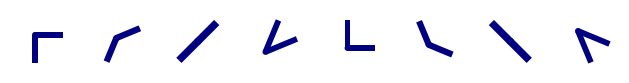

In [5]:
# plot each antenna
fig, ax = plt.subplots(1, 8)
for i in dicNumerator.keys():
    vAntennaBlock((0, 0, 0), *dicNumerator[i]).plot(
        z=0, ax=ax[i], linewidth=0, facecolor="navy"  # patches kwargs
    )
    ax[i].set_axis_off()
    ax[i].set_title("")
fig.tight_layout()
plt.show()

### Building the Metasurface

To properly position the unit cells and build the metasurface, we defined the function `classifyOctant`, which takes the x and y position of a unit cell and returns the octant where the structure belongs. The function is adapted so that the first octant matches the zero-phase antenna.

In [6]:
def classifyOctant(x, y):
    angle = 180 + 180 * (np.arctan2(y, x) / np.pi)
    octant = angle // 45.00
    return octant, angle

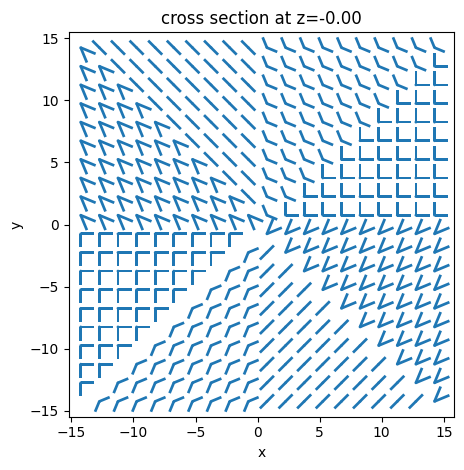

In [7]:
metasurface = None
# loops iterating in both dimensions
for x in range(N):
    for y in range(N):
        # defining the position of the unit cell
        posX = ((N / 2) - x) * lattice_constant - lattice_constant * 0.5
        posY = ((N / 2) - y) * lattice_constant - lattice_constant * 0.5

        # defining angle and octant
        octant, angle = classifyOctant(posX, posY)

        # condition to remove the 45 degree row in the lower half of the metasurface, for it is more similar
        # to what was done in the experiment
        if (abs(angle - 45) >= 0.1) and (((posX == 0) and posY > 0) == False):
            # antenna parameters for a given octant
            armArgs = dicNumerator[octant]

            # adding to the structure
            if (metasurface is None) == True:
                metasurface = vAntennaBlock(
                    (posX, posY, structure_z_position), *armArgs
                )
            else:
                metasurface += vAntennaBlock(
                    (posX, posY, structure_z_position), *armArgs
                )


# define the medium e create the structure object
medium = td.material_library["Au"]["Olmon2012crystal"]  # built-in gold model for the
# frequency range of interest
metasurface = td.Structure(geometry=metasurface, medium=medium)

metasurface.plot(z=structure_z_position, linewidth=0)
plt.show()

### Creating Simulation Object

Since the structures are much smaller than the target wavelength, it is necessary to create a [mesh override](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.MeshOverrideStructure.html) region around the metasurface to properly resolve the structures, while using a coarser mesh for free space propagation.

We will also define a [plane wave](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PlaneWave.html) source with a [gaussian time profile](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.GaussianPulse.html).

Additionally, we will include the substrate region.

For the monitors, we will add a [far-field monitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldProjectionCartesianMonitor.html),
to project the fields on the server side, and a [field monitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) that will store the near-field information for projection locally after the simulation.

In [8]:
mesh_override = td.MeshOverrideStructure(
    geometry=td.Box(center=(0, 0, structure_z_position), size=(sx, sy, thickness)),
    dl=(0.02,) * 3,
)

source_time = td.GaussianPulse(freq0=fcen, fwidth=fwidth)

source_pw = td.PlaneWave(
    center=center_source,
    size=size_source,
    direction="+",
    pol_angle=0,
    source_time=source_time,
)

substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-2 * sx, -2 * sy, -2 * substrate_thickness),
        rmax=(2 * sx, 2 * sy, -sz / 2 + substrate_thickness),
    ),
    medium=td.Medium(permittivity=3.47**2),
)

far_field_monitor = td.FieldProjectionCartesianMonitor(
    center=(0, 0, monitor_z_position),
    size=(td.inf, td.inf, 0),
    normal_dir="+",
    freqs=[fcen],
    x=300 * np.linspace(-0.5, 0.5, 100),
    y=300 * np.linspace(-0.5, 0.5, 100),
    proj_axis=2,
    proj_distance=20 * Wl,
    far_field_approx=False,
    name="farFieldMon",
)

field_monitor = td.FieldMonitor(
    center=far_field_monitor.center,
    size=far_field_monitor.size,
    freqs=far_field_monitor.freqs,
    name="fieldMon",
)

# creating the simulation object

sim = td.Simulation(
    size=(sx, sy, sz),
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=20,  # grid specification and mesh override
        override_structures=[mesh_override],
    ),
    structures=[substrate] + [metasurface],
    sources=[source_pw],
    monitors=[far_field_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(  # all bounderies are pmls in order to simulate a finite structure
        x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.pml()
    ),
)

To make sure that everething is correct, we will plot the y-z and x-y planes of the model.The green line represents the source, the yellow line represents the monitors, the blue area indicates the substrate, and the red area shows the cross-section of the antennas.
the override mesh region is depicted in gray.

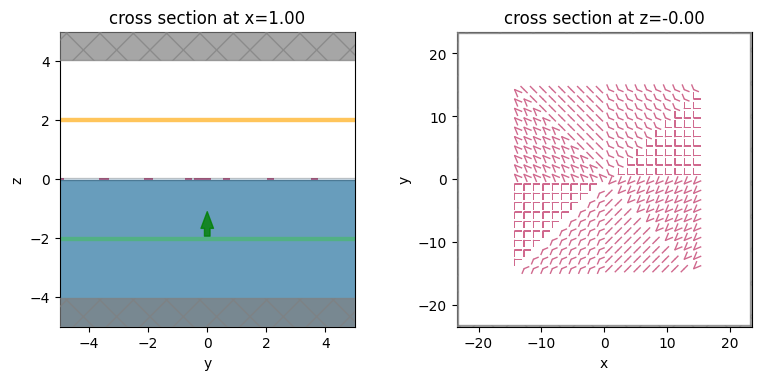

In [9]:
fig, Ax = plt.subplots(1, 2, tight_layout=True, figsize=(8, 3.8))

sim.plot(x=1, ax=Ax[0])
mesh_override.plot(x=1, ax=Ax[0], alpha=0.2)
Ax[0].set_xlim(-5, 5)
Ax[0].set_ylim(-5, 5)

sim.plot(z=structure_z_position, ax=Ax[1])
plt.show()

In [10]:
# estimating the credit cost of the simulation
task_id = web.upload(sim, task_name="vortexMetasurface")
web.estimate_cost(task_id)

20:02:36 -03 Created task 'vortexMetasurface' with task_id                      
             'fdve-7bc96b98-08e2-4fb0-bf7b-a089e9596636' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=610205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc96b98-08e2-4fb0-bf7b-a089e9596636\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=301420;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc96b98-08e2-4fb0-bf7b-a089e9596636\taskId]8;;\]8;id=610205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc96b98-08e2-4fb0-bf7b-a089e9596636\=]8;;\]8;id=844041;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc96b98-08e2-4fb0-bf7b-a089e9596636\fdve]8;;\]8;id=610205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc96b98-08e2-4fb0-bf7b-a089e9596636\-7bc96b98-08e]8;;\
             ]8;id=610205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc96b98-08e2-4fb0-bf7b-a089e9596636\2-4fb0-bf7b-a089e9596636']8;;\.

Output()

20:02:40 -03 Maximum FlexCredit cost: 4.277. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

4.277287960106085

In [117]:
# running the simulation
results = web.run(
    simulation = sim,
    task_name = "vortexMetasurface",
    folder_name = "data",
    path = "data/%s.hdf5" % "1",
    verbose = "True",
)

19:38:40 -03 Created task 'vortexMetasurface' with task_id                      
             'fdve-73fa3197-3f09-4e89-ac57-7e02fc63c120' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=699779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73fa3197-3f09-4e89-ac57-7e02fc63c120\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=422339;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73fa3197-3f09-4e89-ac57-7e02fc63c120\taskId]8;;\]8;id=699779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73fa3197-3f09-4e89-ac57-7e02fc63c120\=]8;;\]8;id=855140;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73fa3197-3f09-4e89-ac57-7e02fc63c120\fdve]8;;\]8;id=699779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73fa3197-3f09-4e89-ac57-7e02fc63c120\-73fa3197-3f0]8;;\
             ]8;id=699779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73fa3197-3f09-4e89-ac57-7e02fc63c120\9-4e89-ac57-7e02fc63c120']8;;\.

Output()

19:38:43 -03 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

19:38:58 -03 status = preprocess

19:39:09 -03 Maximum FlexCredit cost: 4.277. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

19:39:10 -03 running solver

Output()

19:40:10 -03 early shutoff detected at 64%, exiting.

             status = postprocess

Output()

19:40:17 -03 status = success

             View simulation result at                                          
             ]8;id=487329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73fa3197-3f09-4e89-ac57-7e02fc63c120\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=122466;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73fa3197-3f09-4e89-ac57-7e02fc63c120\taskId]8;;\]8;id=487329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73fa3197-3f09-4e89-ac57-7e02fc63c120\=]8;;\]8;id=420966;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73fa3197-3f09-4e89-ac57-7e02fc63c120\fdve]8;;\]8;id=487329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73fa3197-3f09-4e89-ac57-7e02fc63c120\-73fa3197-3f0]8;;\
             ]8;id=487329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73fa3197-3f09-4e89-ac57-7e02fc63c120\9-4e89-ac57-7e02fc63c120']8;;\.

Output()

19:40:44 -03 loading simulation from data/1.hdf5

### Creating Far-Field Projection


In [131]:
# radial distance away from the origin at which to project fields
r_proj = 60 * Wl

# here we add the 'window_size' argument to ensure that the near fields decay to zero at the monitor boundaries
far_field_local_projection = td.FieldProjectionCartesianMonitor(
    center=(0, 0, monitor_z_position),
    size=(td.inf, td.inf, 0),
    normal_dir="+",
    freqs=[fcen],
    x=1000 * np.linspace(-0.5, 0.5, 100),
    y=1000 * np.linspace(-0.5, 0.5, 100),
    proj_axis=2,
    proj_distance=r_proj,
    far_field_approx=False,
    window_size=(0.8, 0.8),
    name="farFieldLocalProjection",
)

projector = td.FieldProjector.from_near_field_monitors(
    sim_data=results,
    near_monitors=[field_monitor],
    normal_dirs=["+"],
    pts_per_wavelength=10,
)
projected = projector.project_fields(far_field_local_projection)
far_field = projected.fields_cartesian

Output()

19:44:49 -03 WARNING: Colocating data that has already been colocated during the
             solver run. For most accurate results when colocating to custom    
             coordinates set 'Monitor.colocate' to 'False' to use the raw data  
             on the Yee grid and avoid double interpolation. Note: the default  
             value was changed to 'True' in Tidy3D version 2.4.0.               

Now we plot the far-field projections: one done in the cloud using the FarFieldMonitor and the other done locally. It is interesting to note the difference between them, as the projection done in the cloud has the window_size argument set to the default (0,0). Without applying the window filter, high-frequency artifacts appear in the projected field as they need to be truncated. On the other hand, applying the spatial filter leads to a more smooth far-field profile, more in agreement with the experimental results. More information about field projection can be found [here](https://www.flexcompute.com/tidy3d/examples/notebooks/FieldProjections/).

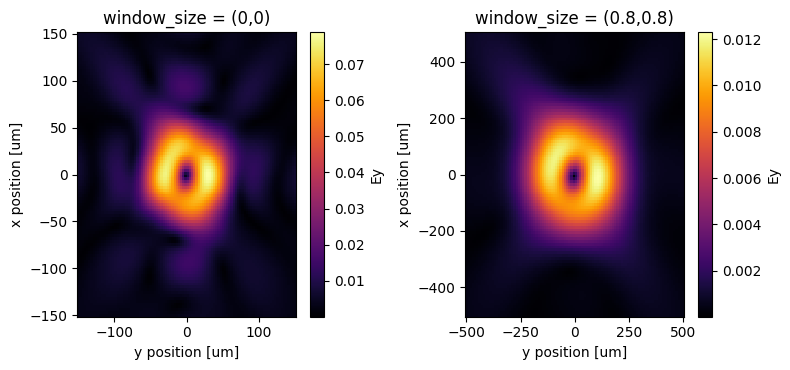

In [132]:
# also plot the projected fields from the FarFieldMonitor
fig, Ax = plt.subplots(1, 2, tight_layout=True, figsize=(8, 3.8))

abs(results["farFieldMon"].fields_cartesian["Ey"]).plot(cmap="inferno", ax=Ax[0])
Ax[0].set_title("window_size = (0,0)")


# plotting only the cross-polarized component (Ey). In the experiments, a polarizer was used to block the
# scattered light with the same polarization as the incident wave.

# visualizing the electric field
abs(far_field["Ey"]).plot(cmap="inferno", ax=Ax[1])
Ax[1].set_title("window_size = (0.8,0.8)")
plt.show()

One can  that the results are consistent with those reported in the original [paper](https://projects.iq.harvard.edu/files/capasso/files/2011_yu_et_al._science.pdf), specifically in Figure 5(c)

Both the simulation and the experiment reveal the formation of a phase singularity at the center of the beam, leading to a region of zero field.

To obtain the phase profile, you can interfere the beam with a collinear Gaussian beam. To reproduce this, use the analytical expression for the Gaussian beam to create an interference pattern with the simulated beam.

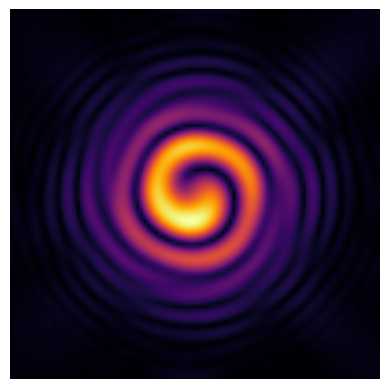

In [133]:
# gaussiam beam function
def E(r, z, lda=1, E0=1, w0=1, n=1):
    k = 2 * np.pi / lda
    zr = np.pi * w0**2 * n / lda
    wz = w0 * np.sqrt(1 + (z / zr) ** 2)
    Rz = z * (1 + (zr / z) ** 2)
    phi = np.arctan(z / zr)

    return (
        E0
        * (w0 / wz)
        * np.exp(-(r**2) / (wz**2))
        * np.exp(-1j * (k * z + k * r**2 / (2 * Rz) - phi))
    )


# creating the data points
x = np.linspace(-40, 40, 100)
y = x.copy()

X, Y = np.meshgrid(x, y)
r = np.sqrt(X**2 + Y**2)

# creating the gaussiam beam field
gb = E(r, 1, 8, w0=20)

# plotting the interference pattern
fig, ax = plt.subplots()
ax.imshow(
    abs(
        results["farFieldMon"].fields_cartesian["Ey"].squeeze().T
        / results["farFieldMon"].fields_cartesian["Ey"].max()
        + gb
    ),
    interpolation="bilinear",
    cmap="inferno",
)
ax.axis("off")
plt.show()

Again, the simulation is consistent with the results reported in Figure 5(e) of the paper.